### This notebook is part of the final machine learning project for class : Machine Learning For Cities
### Taught by Professor Daniel Neill 

## Title: Machine Learning On Yelp Dataset
### The study on recognition of suspicious Five Stars reviews and optimization of Yelp Elite system

In [3]:
import pandas as pd
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BdeuScore, K2Score, BicScore
from pgmpy.inference import VariableElimination
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn import svm

% matplotlib inline

In [4]:
home = pd.read_csv('../Machine Learning for City/yelp.csv', header=None)
home.columns =  ['user_id', 'cool','funny', 'useful', 'stars']

#train,test=train_test_split(home,random_state=9,test_size=0.4)

In [5]:
home.head()

,user_id,cool,funny,useful,stars
0,JPPhyFE-UE453zA6K0TVgw,0,0,0,4
1,fhNxoMwwTipzjO8A9LFe8Q,0,0,1,3
2,tAKjY3bQXH51msJbOHYPmQ,2,0,3,5
3,Sjb5e5-gKoLXueFDMc2R8Q,0,0,0,4
4,2rSeth60_CuWN3ZJ4k41lg,19,11,22,3


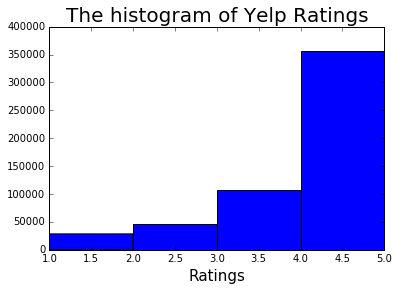

In [6]:
plt.figure(figsize=(6,4))
plt.hist(home.stars, bins = 4)
plt.title("The histogram of Yelp Ratings", size = 20)
plt.xlabel("Ratings", size = 15)

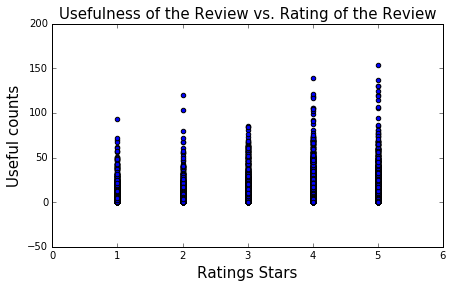

In [6]:
plt.figure(figsize=(7,4))
plt.scatter(home.stars, home.useful)
plt.title("Usefulness of the Review vs. Rating of the Review", size = 15)
plt.xlabel("Ratings Stars", size = 15)
plt.ylabel("Useful counts", size = 15)

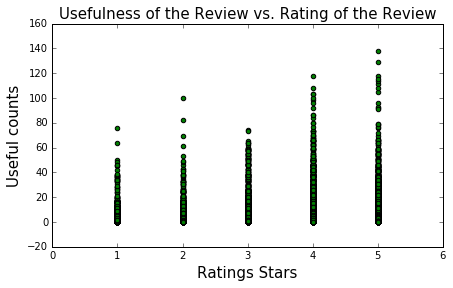

In [7]:
plt.figure(figsize=(7,4))
plt.scatter(home.stars, home.cool, c="g")
plt.title("Usefulness of the Review vs. Rating of the Review", size = 15)
plt.xlabel("Ratings Stars", size = 15)
plt.ylabel("Useful counts", size = 15)

###  it is more likely that a person would give better scores than lower scores, for fake reviews, we assume people will leave good reviews in order to drive up sales in stead of degrade other competitors. 

## We will look into the data specifically for review stand

In [64]:
final_data = pd.read_excel('yelp_user.xlsx')
final_data.drop("name", axis = 1, inplace= True)

In [65]:
final_data.head()

,user_id,cool,funny,useful,stars,review_count,fans,friends,vote_cool,vote_funny,vote_useful,yelp_age,FRE,elite
0,--65q1FpAL_UQtVZ2PTGew,2.695364,1.907285,3.807947,4.046358,151,28,263,656,484,883,93,78.259934,5
1,-0itF0VWVBe3k2AdfUReGA,1.734043,1.500000,2.393617,3.670213,94,2,54,251,189,361,77,69.490000,5
2,-2PFmYGWB6rQhZtRh6PlPA,0.183333,0.166667,0.675000,3.283333,120,0,10,41,91,177,85,79.785834,0
3,-3akdU5UTDn6dwiTCO2cAw,0.736842,0.631579,1.447368,3.934211,76,7,133,83,62,165,82,77.291579,3
4,-4AMRN-7RtozD9s8ZsH04g,1.644068,2.745763,2.644068,3.593220,59,33,219,1325,1674,2067,81,75.822373,6


In [66]:
# binarize the data
final_data.elite = pd.cut(final_data.elite, bins = [0,0.9,13], include_lowest=True, labels=[0,1])


In [67]:
final_data.head()

,user_id,cool,funny,useful,stars,review_count,fans,friends,vote_cool,vote_funny,vote_useful,yelp_age,FRE,elite
0,--65q1FpAL_UQtVZ2PTGew,2.695364,1.907285,3.807947,4.046358,151,28,263,656,484,883,93,78.259934,1
1,-0itF0VWVBe3k2AdfUReGA,1.734043,1.500000,2.393617,3.670213,94,2,54,251,189,361,77,69.490000,1
2,-2PFmYGWB6rQhZtRh6PlPA,0.183333,0.166667,0.675000,3.283333,120,0,10,41,91,177,85,79.785834,0
3,-3akdU5UTDn6dwiTCO2cAw,0.736842,0.631579,1.447368,3.934211,76,7,133,83,62,165,82,77.291579,1
4,-4AMRN-7RtozD9s8ZsH04g,1.644068,2.745763,2.644068,3.593220,59,33,219,1325,1674,2067,81,75.822373,1


In [12]:
final_data[(final_data.elite == 0) & (final_data.stars > 4)].head()

,user_id,cool,funny,useful,stars,review_count,fans,friends,vote_cool,vote_funny,vote_useful,yelp_age,FRE,elite
7,-66ssufl05UYwJGSXfjKVg,0.600000,0.533333,1.283333,4.350000,60,2,7,142,135,277,41,81.564000,0
8,-8BqfYouq3o_UoazAQWwNw,1.687500,1.265625,1.890625,4.375000,64,3,370,124,93,146,52,77.702969,0
9,-8gRkiYaVm3zfoQ4pcg75w,0.462963,0.351852,0.759259,4.055556,54,3,15,36,29,75,72,82.220556,0
97,0NK3ZytUl8PznPx4JXelvw,0.067568,0.027027,0.189189,4.283784,74,1,2,17,8,45,40,82.632973,0
103,0RuJtJkpo4ntJ9Hc7VF-0g,0.322581,0.258065,1.580645,4.193548,62,2,5,35,21,144,66,75.334354,0


In [13]:
final_data[(final_data.elite == 1) & (final_data.stars > 4)].head()

,user_id,cool,funny,useful,stars,review_count,fans,friends,vote_cool,vote_funny,vote_useful,yelp_age,FRE,elite
0,--65q1FpAL_UQtVZ2PTGew,2.695364,1.907285,3.807947,4.046358,151,28,263,656,484,883,93,78.259934,1
10,-8zhUSkiBdIRUfeXM1KM6Q,1.164179,0.567164,2.044776,4.044776,67,6,26,89,41,174,50,75.097761,1
16,-DLZvdwIXxpBKSV6YNsvdA,0.542169,0.361446,1.397590,4.144578,83,7,22,84,54,259,38,73.682410,1
25,-I7HB9_t2lqYF5Yq1pmpfQ,2.875000,1.569444,4.375000,4.138889,72,16,104,324,165,477,52,81.678612,1
30,-KCR0e2Nyc7a7qvqnr9njQ,0.271429,0.314286,0.771429,4.228571,70,5,21,69,131,191,77,77.314286,1


NameError: name 'data' is not defined

# PCA

In [ ]:
data = final_data.iloc[:,1:]
pca = PCA(n_components=2, whiten=True).fit(final_data.iloc[:,1:])
X_pca = pca.transform(final_data.iloc[:,1:])

In [ ]:
print pca.components_

In [ ]:
print pca.explained_variance_ratio_
print sum(pca.explained_variance_ratio_)

## That's pretty cool. Although we have thrown away many dimensions, PCA has chosen the remaining two dimensions well enough that we've captured 98% of the variance in our data in a single dimension alone!

In [ ]:
X_pca.shape

In [ ]:
#colors = cycle('rgb')
target_ids = range(len(final_data))
#plt.figure(figsize= (13,8))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c = final_data.elite, alpha = 0.6)

# SVM(Poly and Gaussian)

In [12]:
from sklearn import svm
from sklearn.cross_validation import train_test_split

/Users/lexu/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [47]:
# binarize the data
final_ = pd.read_excel('yelp_user.xlsx')
final_data = final_.copy()
final_data.drop("name", axis = 1, inplace= True)
final_data.elite = pd.cut(final_data.elite, bins = [0,0.9,13], include_lowest=True, labels=[0,1])

In [197]:
final_.FRE.mean()

78.627652964214889

In [198]:
final_.FRE.max()

100.67363683527169

In [199]:
final_.FRE.min()

17.70836750220279

In [10]:
final_data.head()

,user_id,cool,funny,useful,stars,review_count,fans,friends,vote_cool,vote_funny,vote_useful,yelp_age,FRE,elite
0,--65q1FpAL_UQtVZ2PTGew,2.695364,1.907285,3.807947,4.046358,151,28,263,656,484,883,93,78.259934,1
1,-0itF0VWVBe3k2AdfUReGA,1.734043,1.500000,2.393617,3.670213,94,2,54,251,189,361,77,69.490000,1
2,-2PFmYGWB6rQhZtRh6PlPA,0.183333,0.166667,0.675000,3.283333,120,0,10,41,91,177,85,79.785834,0
3,-3akdU5UTDn6dwiTCO2cAw,0.736842,0.631579,1.447368,3.934211,76,7,133,83,62,165,82,77.291579,1
4,-4AMRN-7RtozD9s8ZsH04g,1.644068,2.745763,2.644068,3.593220,59,33,219,1325,1674,2067,81,75.822373,1


In [13]:
## Normalization:
data = final_data.iloc[:,1:-1]

df_mean = data.mean(axis = 1) # for mean of row, add columns up , use axis 1
df_std = data.std(axis = 1)

final_data_scale = data.apply(lambda x: (x - df_mean)/df_std)

In [19]:
final_data_scale.head() 

,cool,funny,useful,stars,review_count,fans,friends,vote_cool,vote_funny,vote_useful,yelp_age,FRE
0,-0.735283,-0.737941,-0.731531,-0.730727,-0.235144,-0.649946,0.142563,1.467907,0.887858,2.233437,-0.430742,-0.480451
1,-0.776277,-0.778284,-0.770619,-0.759669,0.015163,-0.773995,-0.327949,1.361878,0.830054,2.305437,-0.130660,-0.195079
2,-0.852591,-0.852873,-0.844289,-0.800245,1.170626,-0.855687,-0.686828,-0.163363,0.680934,2.133125,0.579618,0.491572
3,-1.019888,-1.021774,-1.007160,-0.962611,0.328356,-0.907691,1.349440,0.453753,0.077564,1.922679,0.435839,0.351493
4,-0.606740,-0.605289,-0.605423,-0.604172,-0.531153,-0.565417,-0.320293,1.137276,1.597214,2.115138,-0.502159,-0.508983


In [20]:
X = final_data_scale
Y = final_data.iloc[:,-1]

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=1)

### Polynomial Kernal SVM

In [22]:

######################

clf = svm.SVC(kernel='poly', gamma = 2, degree=3, C=1)
clf.fit(X_train, Y_train)

#Report IS and OS result:
correct_IS=1.0*(clf.predict(X_train)==np.asarray(Y_train)).sum()/len(Y_train)
correct_OS=1.0*(clf.predict(X_test)==np.asarray(Y_test)).sum()/len(Y_test)

print "we successfully(IS) predict the {:.4} percent of data".format((correct_IS)*100)
print "we successfully(OS) predict the {:.4} percent of data".format((correct_OS)*100)

we successfully(IS) predict the 83.91 percent of data
we successfully(OS) predict the 80.5 percent of data


### Gussian Kernal SVM

In [24]:
# #Gussian Kernal SVM
clf = svm.SVC(kernel='rbf',gamma=2, C=1,degree = 3) 

clf.fit(X_train, Y_train)

#right_IS=1.0*(clf.predict(X_test)==np.asarray(Y_test)).sum()/len(Y_test)
right_OS=1.0*(clf.predict(X_test)==np.asarray(Y_test)).sum()/len(Y_test)
print "we successfully(OS) predict the {} percent of data".format((right_OS)*100)

we successfully(OS) predict the 79.5932678822 percent of data


### Linear Kernal SVM

In [25]:
clf = svm.SVC(kernel='linear',C=1, gamma = 2)
clf.fit(X_train, Y_train)
correct=1.0*(clf.predict(X_test)==np.asarray(Y_test)).sum()/len(Y_test)
print "we successfully(OS) predict the {} percent of data by {}".format((correct)*100,'linear')

we successfully(OS) predict the 78.6816269285 percent of data by linear


# Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier as DTC

In [27]:
## Control the complexity of the Decision Tree
OS=[]
for i in range(2,50,2):
    rf=DTC(max_leaf_nodes=i)
    rf.fit(X_train,Y_train)
    OS.append(rf.score(X_test,Y_test))

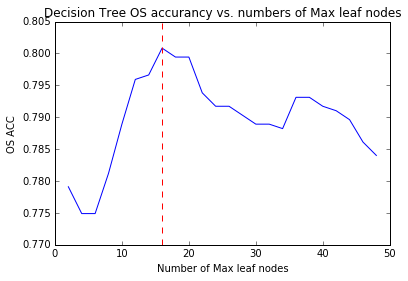

In [205]:

plt.plot(range(2,50,2),OS)
plt.axvline(16,color='r',linestyle='--')
plt.title("Decision Tree OS accurancy vs. numbers of Max leaf nodes")
plt.xlabel("Number of Max leaf nodes")
plt.ylabel('OS ACC')

In [29]:
rf=DTC(max_leaf_nodes=16)
rf.fit(X_train,Y_train)
rf.score(X_test,Y_test)

0.80084151472650766

### Let's use ROC AUC instead of accuracy.

In [206]:
from sklearn.metrics import roc_auc_score as rs

AUC_IS=[]
AUC_OS=[]
for i in range(10):
    X_train,X_test,Y_train,Y_test=train_test_split(X, Y, test_size=0.3)
    rf=DTC()
    rf.fit(X_train,Y_train)
    pred=rf.predict(X_test)
    AUC_OS.append(rs(np.array(Y_test),pred))
    AUC_IS.append(rs(np.array(Y_train),rf.predict(X_train)))

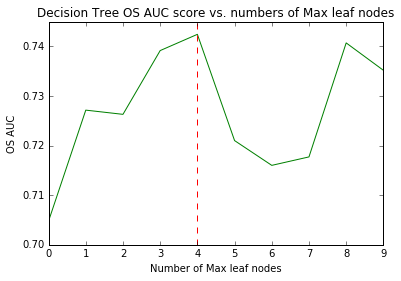

In [214]:
plt.plot(range(0,10,1), AUC_OS, c = 'g')
plt.axvline(4,color='r',linestyle='--')
plt.title("Decision Tree OS AUC score vs. numbers of Max leaf nodes")
plt.xlabel("Number of Max leaf nodes")
plt.ylabel('OS AUC')

In [31]:
print "IS AUC: {}".format(np.mean(AUC_IS))
print "OS AUC: {}".format(np.mean(AUC_OS))

IS AUC: 1.0
OS AUC: 0.727793356657


### The feature importances. The higher, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance

In [32]:
Feature_importance=pd.DataFrame([list(X_train.columns),list(rf.feature_importances_)]).T
Feature_importance.columns=["variables","importance"]
Feature_importance.sort_values(by="importance",ascending=False).iloc[:3,:]

,variables,importance
7,vote_cool,0.372418
6,friends,0.155433
5,fans,0.11073


In [33]:
## USE THE FEATURES TO TRAIN THE MODEL:
#Let's generate our new training and testing model by these three features.
X_train_simple= X_train.loc[:,["vote_cool","friends","vote_useful"]]
X_test_simple= X_test.loc[:,["vote_cool","friends","vote_useful"]]

#Let's see the performance of this simple model:
real=np.array(Y_test)
rf = DTC(max_leaf_nodes=16) # Here of course we could remove this limit. But you could have a very 
                             #big graph for next question.
rf.fit(X_train_simple, Y_train)
pred=rf.predict(X_test_simple)
print("The AUC score for this simple model with 3 features is : {}".format(rs(real,pred)))

The AUC score for this simple model with 3 features is : 0.792675732067


# Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier as RFC
rf = RFC(n_estimators=30, n_jobs=-1, max_leaf_nodes=15)
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=15,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [35]:
pred=rf.predict(X_test)
pred.shape
print rs(np.array(Y_test), pred)

0.797653479695


In [36]:
Feature_importance=pd.DataFrame([list(X_train.columns),list(rf.feature_importances_)]).T
Feature_importance.columns=["variables","importance"]
Feature_importance.sort_values(by="importance",ascending=False).iloc[:3,:]

,variables,importance
7,vote_cool,0.249068
11,FRE,0.208194
9,vote_useful,0.169123


In [37]:
## USE THE FEATURES TO TRAIN THE MODEL:
#Let's generate our new training and testing model by these three features.
X_train_simple= X_train.loc[:,["vote_cool","friends","FRE"]]
X_test_simple= X_test.loc[:,["vote_cool","friends","FRE"]]

#Let's see the performance of this simple model:
real=np.array(Y_test)
rf = RFC(n_estimators=30, n_jobs=-1,max_leaf_nodes=15) # Here of course we could remove this limit. But you could have a very 
                             #big graph for next question.
rf.fit(X_train_simple, Y_train)
pred=rf.predict(X_test_simple)
print("The AUC score for this simple model with 3 features is : {}".format(rs(real,pred)))

The AUC score for this simple model with 3 features is : 0.789080406607


# K-means

In [168]:
data = final_
more_4_star = data[data.stars > 4.5].sort_values("useful", ascending = 0)

In [169]:
more_4_star.shape

(97, 14)

### more than 4 stars

In [170]:
## more 4 stars
data = more_4_star.iloc[:,1:]

df_mean = data.mean(axis = 1) # for mean of row, add columns up , use axis 1
df_std = data.std(axis = 1)

data_scale = data.apply(lambda x: (x - df_mean)/df_std)

# kmeans 
model = KMeans(n_clusters=2).fit(data_scale)
labels = model.labels_
data_scale['kmean_label'] = labels

data_scale["user_id"] = more_4_star.iloc[:,0]

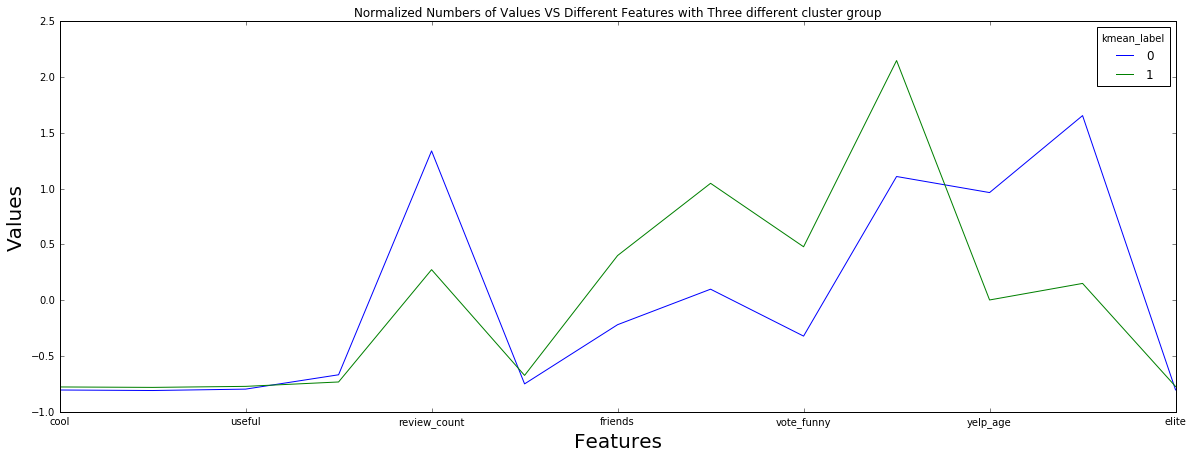

In [171]:
ax = data_scale.groupby("kmean_label").mean().T.plot(figsize=(20,7))
ax.set_ylabel("Values", fontsize = 20)
ax.set_xlabel("Features",  fontsize = 20)

ax.set_title ("Normalized Numbers of Values VS Different Features with Three different cluster group")

## Comment From the plot: 
### 1. the more reviews the higher scores for the FRE
### 2. the less the reviews, the higher cool vote count, the hight vote count. (those users reviews less, but vote more to others, they are more viewers, instead of reviews)
### 3. the more reviews, the lower the vote for others, the less friends.


## Gaussian Mixture

In [172]:
more_4_star.head(10)

,user_id,cool,funny,useful,stars,review_count,fans,friends,vote_cool,vote_funny,vote_useful,yelp_age,FRE,elite
2814,_pc89S47Dk-yp1VjrbVyJQ,38.041096,26.753425,40.712329,4.630137,73,232,1035,4842,3417,5111,81,66.910000,0
1445,IK-bpyw7JNVxkExX4eSHpA,6.445783,5.132530,9.024096,4.554217,83,100,390,799,628,1107,123,82.202170,6
3046,d9OpCGxR0RQTXwZc0DWBBw,6.215190,3.860759,6.898734,4.506329,79,36,166,670,409,749,40,85.324304,2
4598,xthFXWIoXm06OKgXj0ROCQ,5.727941,2.904412,5.970588,4.595588,136,104,324,1153,590,1250,79,71.699265,0
880,AZ-KneIf2C3csDftss2aDg,5.017391,3.043478,5.121739,4.773913,115,40,137,611,381,660,60,80.708087,1
2480,WTT0hi0IOO-zl_s5e-qQ4Q,4.931034,3.712644,5.034483,4.505747,87,22,137,1174,887,1265,45,75.615057,2
2146,Rro65XbBIgTc392wf4oAMg,3.698113,1.905660,3.981132,4.924528,53,13,79,269,139,297,119,73.332265,2
1523,JRdTRHchEWH_qba8Y8P6cQ,2.777778,2.537037,3.611111,4.666667,54,36,129,16778,13278,17897,98,75.558889,0
659,7G-n3IpqUDiBKD6t5unHkg,2.485294,1.713235,3.397059,4.566176,136,49,188,504,375,786,51,74.434118,3
652,7CjXfvnVxL1OJO1Tboq01Q,2.634328,2.358209,3.291045,4.776119,134,22,126,596,474,767,104,82.748135,2


In [173]:
more_4_star.FRE.mean()

78.08251653699331

### Train the good data

In [174]:
train_data = more_4_star[(more_4_star.elite > 0) & (more_4_star.FRE < more_4_star.FRE.mean())]

In [175]:
data = train_data.iloc[:,1:]
GM=GaussianMixture(n_components=5, random_state=220)

GM.fit(data)
df_gaussian = pd.DataFrame(
    {'GM_Score': GM.score_samples(more_4_star.iloc[:,1:]),
     'id': more_4_star.user_id})

In [176]:
df_gaussian.sort_values("GM_Score", ascending=True)[:10]

,GM_Score,id
1523,-1.077026e+12,JRdTRHchEWH_qba8Y8P6cQ
2814,-6.131002e+10,_pc89S47Dk-yp1VjrbVyJQ
1445,-7.900028e+09,IK-bpyw7JNVxkExX4eSHpA
2649,-5.825533e+09,YyavHs3U4XaX9shLcUV6bA
3262,-4.743987e+09,fvrJU4f7euDYwjHIURtFOA
652,-2.536743e+09,7CjXfvnVxL1OJO1Tboq01Q
4598,-2.074399e+09,xthFXWIoXm06OKgXj0ROCQ
1145,-2.034484e+09,EA4DUm9DW20r3No1sixMbg
2441,-1.534653e+09,VunWX7xcjm9iUJe7Ds9XFQ
880,-9.101151e+08,AZ-KneIf2C3csDftss2aDg


## Isolation Forest

In [177]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

data = more_4_star.iloc[:,1:]

# fit the model
clf = IsolationForest(max_samples=100, random_state=220)
clf.fit(data)

df_isolation = pd.DataFrame(
    {'Iso_Score': clf.decision_function(more_4_star.iloc[:,1:]),
     'id': more_4_star.user_id})

In [218]:
df_isolation.sort_values("Iso_Score")[:10]

,Iso_Score,id
2814,-0.226861,_pc89S47Dk-yp1VjrbVyJQ
1523,-0.144194,JRdTRHchEWH_qba8Y8P6cQ
1445,-0.115229,IK-bpyw7JNVxkExX4eSHpA
4598,-0.066050,xthFXWIoXm06OKgXj0ROCQ
3046,-0.039082,d9OpCGxR0RQTXwZc0DWBBw
2480,-0.027772,WTT0hi0IOO-zl_s5e-qQ4Q
2146,-0.023888,Rro65XbBIgTc392wf4oAMg
880,-0.017411,AZ-KneIf2C3csDftss2aDg
226,0.003937,2AbBZM7n9EMwa0nK1yl0CA
652,0.004357,7CjXfvnVxL1OJO1Tboq01Q


In [216]:
# merge both lists see if anyone appears both list
tem_ = df_gaussian.sort_values("GM_Score", ascending=True).head(10)
tem_

,GM_Score,id
1523,-1.077026e+12,JRdTRHchEWH_qba8Y8P6cQ
2814,-6.131002e+10,_pc89S47Dk-yp1VjrbVyJQ
1445,-7.900028e+09,IK-bpyw7JNVxkExX4eSHpA
2649,-5.825533e+09,YyavHs3U4XaX9shLcUV6bA
3262,-4.743987e+09,fvrJU4f7euDYwjHIURtFOA
652,-2.536743e+09,7CjXfvnVxL1OJO1Tboq01Q
4598,-2.074399e+09,xthFXWIoXm06OKgXj0ROCQ
1145,-2.034484e+09,EA4DUm9DW20r3No1sixMbg
2441,-1.534653e+09,VunWX7xcjm9iUJe7Ds9XFQ
880,-9.101151e+08,AZ-KneIf2C3csDftss2aDg


## Train the model with good users and TEST ON the other USERS data

## Total 6 out of 10 users 

In [180]:
more_4_star.loc[tem_.index]

,user_id,cool,funny,useful,stars,review_count,fans,friends,vote_cool,vote_funny,vote_useful,yelp_age,FRE,elite
2814,_pc89S47Dk-yp1VjrbVyJQ,38.041096,26.753425,40.712329,4.630137,73,232,1035,4842,3417,5111,81,66.910000,0
1523,JRdTRHchEWH_qba8Y8P6cQ,2.777778,2.537037,3.611111,4.666667,54,36,129,16778,13278,17897,98,75.558889,0
1445,IK-bpyw7JNVxkExX4eSHpA,6.445783,5.132530,9.024096,4.554217,83,100,390,799,628,1107,123,82.202170,6
4598,xthFXWIoXm06OKgXj0ROCQ,5.727941,2.904412,5.970588,4.595588,136,104,324,1153,590,1250,79,71.699265,0
880,AZ-KneIf2C3csDftss2aDg,5.017391,3.043478,5.121739,4.773913,115,40,137,611,381,660,60,80.708087,1
652,7CjXfvnVxL1OJO1Tboq01Q,2.634328,2.358209,3.291045,4.776119,134,22,126,596,474,767,104,82.748135,2


## Anomaly Detection with Bayesian Models (TOO EXPENSIVE TO COMPUTE!!!!)

In [190]:
train_data_baye = more_4_star[(more_4_star.elite > 0)]

In [191]:
## Normalization:
data = train_data_baye.iloc[:,1:]

df_mean = data.mean(axis = 1) # for mean of row, add columns up , use axis 1
df_std = data.std(axis = 1)

data_scale = data.apply(lambda x: (x - df_mean)/df_std)

In [192]:
data_scale.head()

,cool,funny,useful,stars,review_count,fans,friends,vote_cool,vote_funny,vote_useful,yelp_age,FRE,elite
1445,-0.688940,-0.692548,-0.681855,-0.694137,-0.478594,-0.431883,0.364942,1.488740,1.018888,2.335024,-0.368687,-0.480786,-0.690165
3046,-0.637075,-0.646032,-0.634474,-0.643576,-0.360180,-0.523765,-0.029207,1.888156,0.895236,2.188695,-0.508548,-0.336121,-0.653111
880,-0.669901,-0.678334,-0.669455,-0.670941,-0.200028,-0.520447,-0.106039,1.919007,0.936390,2.128347,-0.435002,-0.346532,-0.687064
2480,-0.587416,-0.589966,-0.587199,-0.588306,-0.415652,-0.551692,-0.311007,1.859344,1.258678,2.049799,-0.503555,-0.439480,-0.593550
2146,-0.769638,-0.787381,-0.766837,-0.757498,-0.281612,-0.677561,-0.024246,1.856512,0.569678,2.133676,0.371703,-0.080349,-0.786447


In [195]:
from pgmpy.estimators import ExhaustiveSearch
bic = BicScore(data_scale)
es = ExhaustiveSearch(data_scale, scoring_method=bic)
best_model = es.estimate()
print(best_model.edges())


/Users/lexu/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pgmpy-0.1.3-py2.7.egg/pgmpy/estimators/ExhaustiveSearch.py:87: UserWarning: Generating all DAGs of n nodes likely not feasible for n>6!
  warn("Generating all DAGs of n nodes likely not feasible for n>6!")
/Users/lexu/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pgmpy-0.1.3-py2.7.egg/pgmpy/estimators/ExhaustiveSearch.py:88: UserWarning: Attempting to search through 91343852333181432387730302044767688728495783936 graphs
  warn("Attempting to search through {0} graphs".format(2**(len(nodes)*(len(nodes)-1))))


KeyboardInterrupt: 

In [193]:
hc = HillClimbSearch(data_scale, scoring_method=BicScore(data_scale))
best_model = hc.estimate()
print(best_model.edges())


[]


In [ ]:
model = BayesianModel(best_model.edges())
model.fit(data, estimator=BayesianEstimator)

infer = VariableElimination(model)

In [ ]:
def logLiklihood(x,infer):
    a=x.cool
    b=x.funny
    c=x.useful
    d=x.stars
    print (a,b,c,d)
    return np.log((infer.query(["cool"], evidence={'funny': b})['cool']).values[a])\
            +np.log((infer.query(["funny"])['funny']).values[b])\
            +np.log((infer.query(["useful"], evidence={'cool': a})['useful']).values[c])\
            +np.log((infer.query(["stars"], evidence={'cool': a})['stars']).values[d])

In [ ]:
exmp= data.apply(lambda x: logLiklihood(x,infer),axis=1)